<a href="https://colab.research.google.com/github/Txlu-OG/AI-Project/blob/main/AI_Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Unsupervised Image Clustering and Visualization (MNIST)

**Author: Adedamola Ogundipe**

This Jupyter Notebook implements an **end-to-end pipeline** for unsupervised learning on the MNIST handwritten digits dataset using **K-Means clustering** and **dimensionality reduction** techniques (**PCA** and **t-SNE**).

**Main steps covered:**

1. Data loading and preprocessing (MNIST via scikit-learn)
2. Exploratory Data Analysis (EDA)
3. K-Means clustering and elbow method for choosing the number of clusters
4. Cluster centroid visualization and interpretation
5. Using the trained K-Means model to predict cluster labels for new images
6. Evaluation with unsupervised metrics (ARI, NMI) and confusion matrix
7. Dimensionality reduction with PCA and t-SNE
8. Cluster visualization in 2D space


In [1]:
# Import All the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# For nicer plots
%matplotlib inline

# Set a random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
# 1. Data Loading: MNIST from scikit-learn

print("Loading MNIST dataset from scikit-learn")

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data
y = mnist.target

# Convert labels to integers
y = y.astype(int)

print("Data shape (samples, features):", X.shape)
print("Labels shape:", y.shape)
print("Unique labels:", np.unique(y))


Loading MNIST dataset from scikit-learn
Data shape (samples, features): (70000, 784)
Labels shape: (70000,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


Digit distribution:
Digit 0: 6903 samples
Digit 1: 7877 samples
Digit 2: 6990 samples
Digit 3: 7141 samples
Digit 4: 6824 samples
Digit 5: 6313 samples
Digit 6: 6876 samples
Digit 7: 7293 samples
Digit 8: 6825 samples
Digit 9: 6958 samples

Showing some sample images from the dataset:


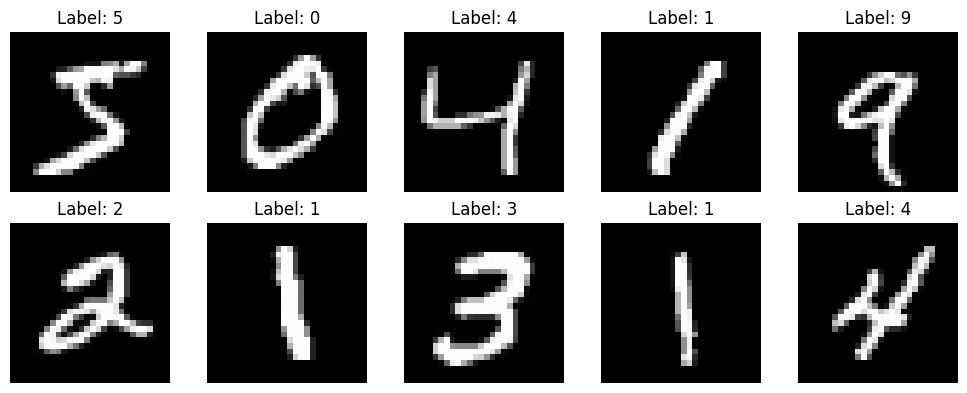

In [3]:
# 2. Exploratory Data Analysis (EDA)

# Label distribution
unique, counts = np.unique(y, return_counts=True)
print("Digit distribution:")
for digit, count in zip(unique, counts):
    print(f"Digit {digit}: {count} samples")


def plot_samples(images, labels, n_rows=2, n_cols=5):
    """Plot a grid of sample digit images."""
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap="gray")
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


print("\nShowing some sample images from the dataset:")
plot_samples(X, y, n_rows=2, n_cols=5)


In [4]:
# 3. Data Preprocessing: Normalization and Train/Test Split

# Normalize pixel values to [0, 1]
X_norm = X / 255.0

# Standardize features (mean = 0, variance = 1) - good for K-Means and PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_norm)

print("Scaled data shape:", X_scaled.shape)

# Train-test split (for evaluating clustering on 'new' images)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Keep an unscaled version (normalized 0–1) for visualization later
X_train_raw, X_test_raw, _, _ = train_test_split(
    X_norm, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)


Scaled data shape: (70000, 784)
Train shape: (56000, 784)
Test shape: (14000, 784)


Fitting KMeans for k=8...
Fitting KMeans for k=9...
Fitting KMeans for k=10...
Fitting KMeans for k=11...
Fitting KMeans for k=12...
Fitting KMeans for k=13...
Fitting KMeans for k=14...


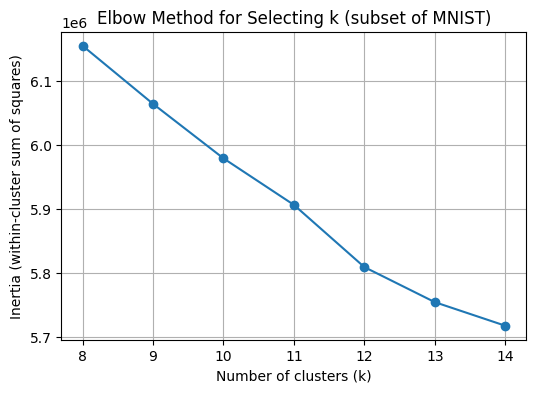


Interpretation: Look for the 'elbow' in the curve to choose k


In [5]:
# 4. Choosing the Number of Clusters: Elbow Method

# Use a subset for speed
subset_size = 10000
X_subset = X_train[:subset_size]

k_values = range(8, 15)  # Trying k from 8 to 14
inertias = []

for k in k_values:
    print(f"Fitting KMeans for k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(X_subset)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(k_values, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster sum of squares)")
plt.title("Elbow Method for Selecting k (subset of MNIST)")
plt.grid(True)
plt.show()

print("\nInterpretation: Look for the 'elbow' in the curve to choose k"
)

In [6]:
# 5. Final K-Means Clustering Model

# Based on the elbow plot and domain knowledge (digits 0–9), we choose k = 10
optimal_k = 10

kmeans_final = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=10)
print("Training final K-Means model with k =", optimal_k)
kmeans_final.fit(X_train)

# Cluster labels for training data
train_clusters = kmeans_final.labels_
print("Cluster labels shape (train):", train_clusters.shape)


Training final K-Means model with k = 10
Cluster labels shape (train): (56000,)


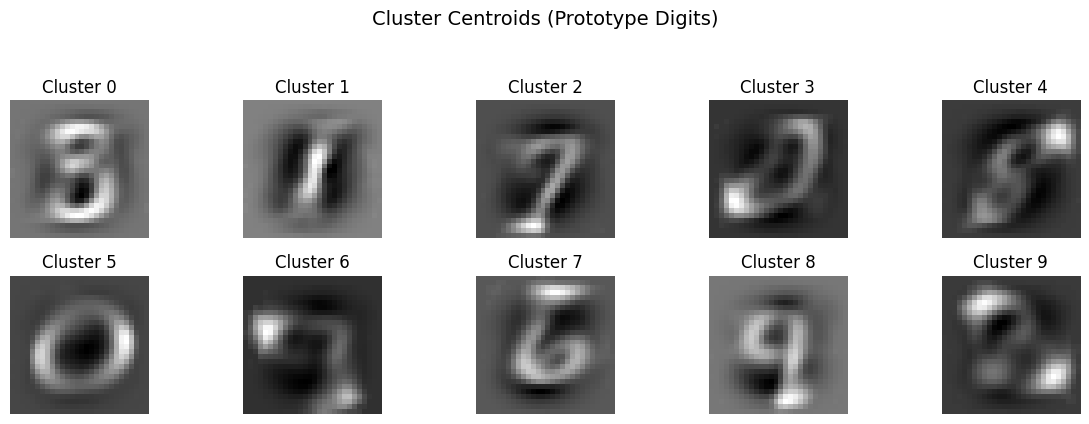

Each centroid represents the 'average' digit image for that cluster.


In [7]:
# 6. Visualizing Cluster Centroids (Prototype Digits)

centroids = kmeans_final.cluster_centers_  # shape: (k, 784)

plt.figure(figsize=(12, 4))
for i in range(optimal_k):
    plt.subplot(2, optimal_k // 2, i + 1)
    plt.imshow(centroids[i].reshape(28, 28), cmap="gray")
    plt.title(f"Cluster {i}")
    plt.axis("off")

plt.suptitle("Cluster Centroids (Prototype Digits)", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

print("Each centroid represents the 'average' digit image for that cluster.")


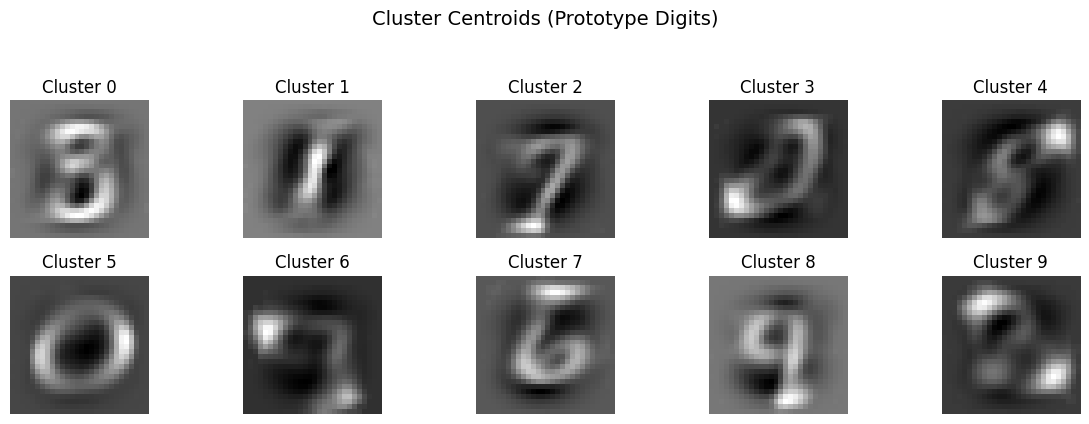

Each centroid represents the 'average' digit image for that cluster.


In [8]:
# 6. Visualizing Cluster Centroids (Prototype Digits)

centroids = kmeans_final.cluster_centers_  # shape: (k, 784)

plt.figure(figsize=(12, 4))
for i in range(optimal_k):
    plt.subplot(2, optimal_k // 2, i + 1)
    plt.imshow(centroids[i].reshape(28, 28), cmap="gray")
    plt.title(f"Cluster {i}")
    plt.axis("off")

plt.suptitle("Cluster Centroids (Prototype Digits)", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

print("Each centroid represents the 'average' digit image for that cluster.")


Cluster labels shape (test): (14000,)
Showing some test images with their assigned cluster labels:


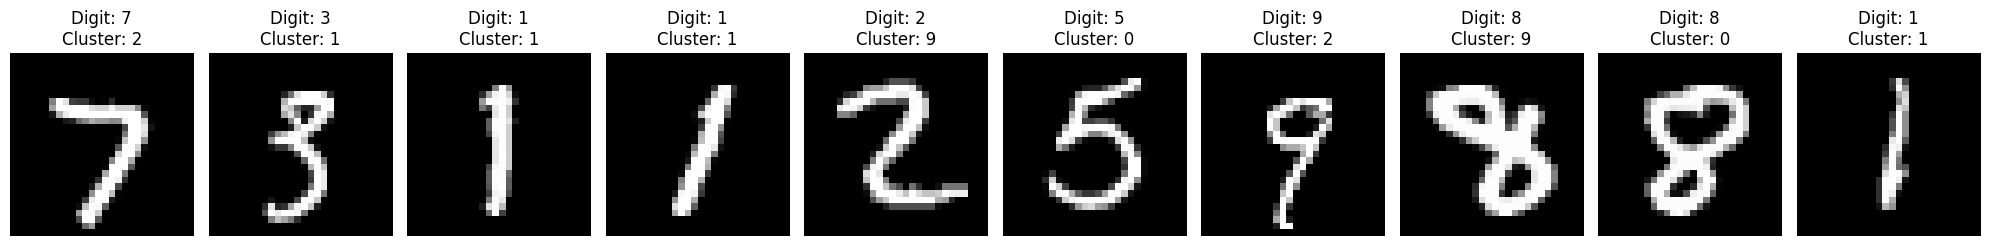

In [10]:
# 7. Using the Trained Model to Predict Clusters for New Images

# Predict clusters for test images (unseen during training)
test_clusters = kmeans_final.predict(X_test)
print("Cluster labels shape (test):", test_clusters.shape)


def show_test_clusters(images_raw, true_labels, cluster_labels, n_samples=10):
    """Show some test images with their true digit and predicted cluster ID."""
    plt.figure(figsize=(n_samples * 2, 2.5))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(images_raw[i].reshape(28, 28), cmap="gray")
        plt.title(f"Digit: {true_labels[i]}\nCluster: {cluster_labels[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


print("Showing some test images with their assigned cluster labels:")
show_test_clusters(X_test_raw, y_test, test_clusters, n_samples=10)


In [11]:
# 8. Model Evaluation with Unsupervised Metric

# Adjusted Rand Index (ARI) for train and test
ari_train = adjusted_rand_score(y_train, train_clusters)
ari_test = adjusted_rand_score(y_test, test_clusters)

# Normalized Mutual Information (NMI) for test
nmi_test = normalized_mutual_info_score(y_test, test_clusters)

print(f"Adjusted Rand Index (train): {ari_train:.4f}")
print(f"Adjusted Rand Index (test):  {ari_test:.4f}")
print(f"Normalized Mutual Information (test): {nmi_test:.4f}")


# Confusion matrix between true digit labels and cluster IDs (test set)
cm = confusion_matrix(y_test, test_clusters)
print("\nConfusion matrix shape:", cm.shape)
print("Confusion matrix (rows = true digits, columns = cluster IDs):\n")
print(cm)


Adjusted Rand Index (train): 0.3151
Adjusted Rand Index (test):  0.3206
Normalized Mutual Information (test): 0.4344

Confusion matrix shape: (10, 10)
Confusion matrix (rows = true digits, columns = cluster IDs):

[[ 278    8    3  246   51  728    1   50    2   14]
 [   5 1534    1    0   24    0    0    6    2    3]
 [ 141  167    9  368    4    8    9  163   38  491]
 [ 822  124   15  249   18    2   17   14   27  140]
 [   0   93  159   11  178    8   66   26  804   20]
 [ 452   94   19   40  498    9   10   21   57   63]
 [  27  118    1    8   11   64    1 1059    6   80]
 [   1   96  813    2   26    1  195    1  321    3]
 [ 525  222   44   22  404    9   14    8   74   43]
 [  26   75  468    2   19   11   92    2  693    3]]


Total variance explained by first 50 components: 0.5521


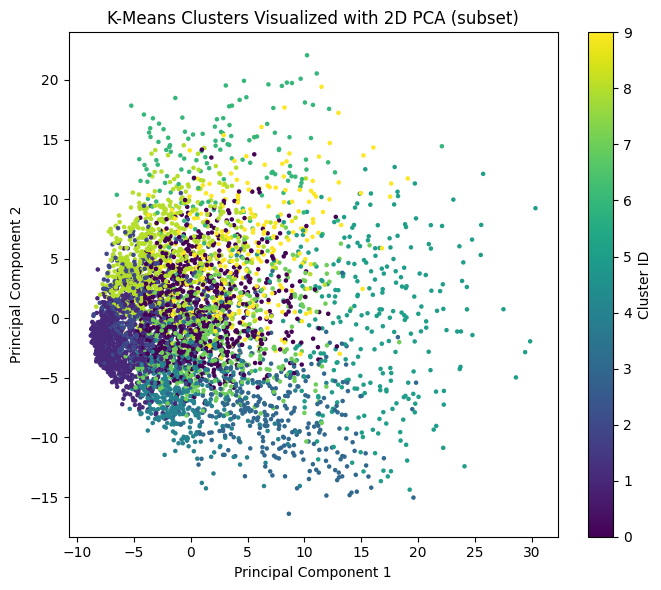

In [12]:
# 9. Dimensionality Reduction with PCA

# First, reduce dimensionality to 50 components for denoising and efficiency
pca_50 = PCA(n_components=50, random_state=RANDOM_STATE)
X_train_pca50 = pca_50.fit_transform(X_train)
X_test_pca50 = pca_50.transform(X_test)

explained_variance_50 = pca_50.explained_variance_ratio_.sum()
print(f"Total variance explained by first 50 components: {explained_variance_50:.4f}")


# Now, 2D PCA for visualization
pca_2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_pca2 = pca_2.fit_transform(X_train)

# Plot a subset for readability
subset_vis = 5000
X_vis = X_train_pca2[:subset_vis]
clusters_vis = train_clusters[:subset_vis]

plt.figure(figsize=(7, 6))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=clusters_vis, s=5)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clusters Visualized with 2D PCA (subset)")
plt.tight_layout()
plt.show()


Running t-SNE on a subset of 2000 samples (this may take a while)...


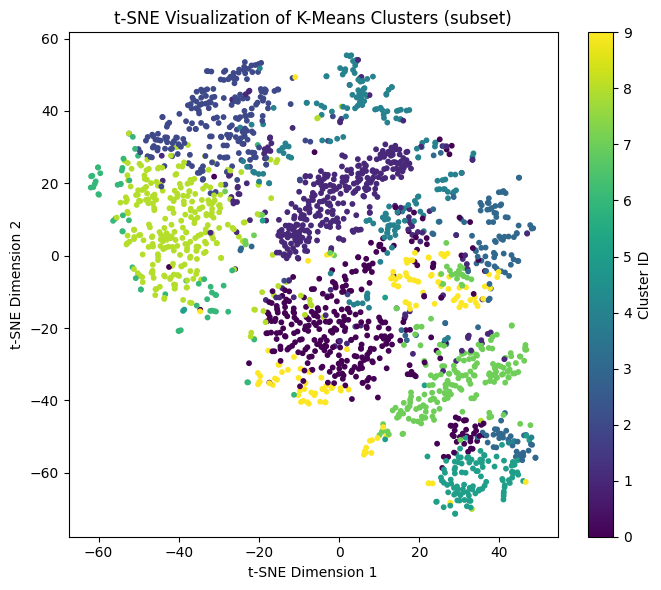

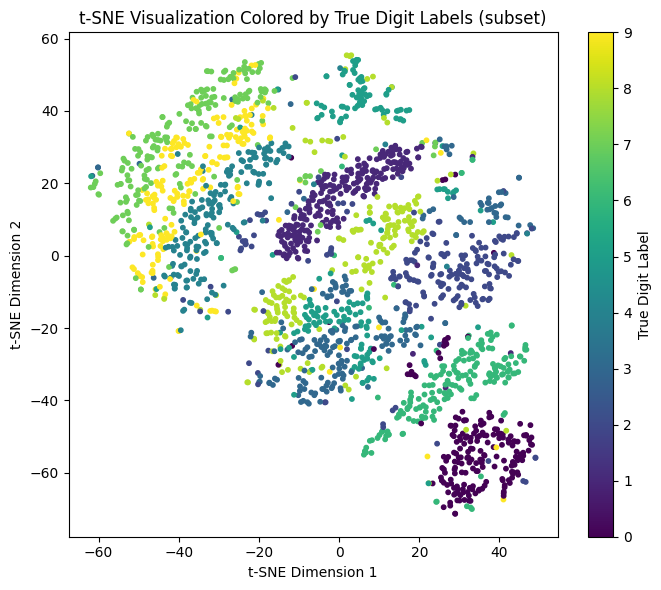

In [13]:
# 10. Dimensionality Reduction and Visualization with t-SNE

# t-SNE is computationally expensive; use a smaller subset
tsne_size = 2000
X_tsne_subset = X_train[:tsne_size]
clusters_tsne_subset = train_clusters[:tsne_size]
labels_tsne_subset = y_train[:tsne_size]

print("Running t-SNE on a subset of", tsne_size, "samples (this may take a while)...")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=RANDOM_STATE,
    init="pca"
)

X_tsne_2d = tsne.fit_transform(X_tsne_subset)

# Plot 1: colored by cluster ID
plt.figure(figsize=(7, 6))
scatter = plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=clusters_tsne_subset, s=10)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of K-Means Clusters (subset)")
plt.tight_layout()
plt.show()

# Plot 2: colored by true digit label
plt.figure(figsize=(7, 6))
scatter = plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=labels_tsne_subset, s=10)
plt.colorbar(scatter, label="True Digit Label")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization Colored by True Digit Labels (subset)")
plt.tight_layout()
plt.show()



Project 4-Unsupervised Image Clustering and Visualization.ipynb
Project 4-Unsupervised Image Clustering and Visualization.ipynb_
Project 4: Unsupervised Image Clustering and Visualization (MNIST)
Author: Dandy Eriametor

Business Intelligence Analyst

Student Number: DE111080

This Jupyter Notebook implements an end-to-end pipeline for unsupervised learning on the MNIST handwritten digits dataset using K-Means clustering and dimensionality reduction techniques (PCA and t-SNE).

Main steps covered:

Data loading and preprocessing (MNIST via scikit-learn)
Exploratory Data Analysis (EDA)
K-Means clustering and elbow method for choosing the number of clusters
Cluster centroid visualization and interpretation
Using the trained K-Means model to predict cluster labels for new images
Evaluation with unsupervised metrics (ARI, NMI) and confusion matrix
Dimensionality reduction with PCA and t-SNE
Cluster visualization in 2D space

[ ]
# Import All the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# For nicer plots
%matplotlib inline

# Set a random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


[ ]
# 1. Data Loading: MNIST from scikit-learn

print("Loading MNIST dataset from scikit-learn")

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data        
y = mnist.target        

# Convert labels to integers
y = y.astype(int)

print("Data shape (samples, features):", X.shape)
print("Labels shape:", y.shape)
print("Unique labels:", np.unique(y))

Loading MNIST dataset from scikit-learn
Data shape (samples, features): (70000, 784)
Labels shape: (70000,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]

[ ]
# 2. Exploratory Data Analysis (EDA)

# Label distribution
unique, counts = np.unique(y, return_counts=True)
print("Digit distribution:")
for digit, count in zip(unique, counts):
    print(f"Digit {digit}: {count} samples")


def plot_samples(images, labels, n_rows=2, n_cols=5):
…
print("\nShowing some sample images from the dataset:")
plot_samples(X, y, n_rows=2, n_cols=5)



[ ]
# 3. Data Preprocessing: Normalization and Train/Test Split

# Normalize pixel values to [0, 1]
X_norm = X / 255.0

# Standardize features (mean = 0, variance = 1) - good for K-Means and PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_norm)

print("Scaled data shape:", X_scaled.shape)
…X_train_raw, X_test_raw, _, _ = train_test_split(
    X_norm, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

Scaled data shape: (70000, 784)
Train shape: (56000, 784)
Test shape: (14000, 784)

[ ]
# 4. Choosing the Number of Clusters: Elbow Method

# Use a subset for speed
subset_size = 10000
X_subset = X_train[:subset_size]

k_values = range(8, 15)  # Trying k from 8 to 14
inertias = []

for k in k_values:
…plt.grid(True)
plt.show()

print("\nInterpretation: Look for the 'elbow' in the curve to choose k"
)


[ ]
# 5. Final K-Means Clustering Model

# Based on the elbow plot and domain knowledge (digits 0–9), we choose k = 10
optimal_k = 10

kmeans_final = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=10)
print("Training final K-Means model with k =", optimal_k)
kmeans_final.fit(X_train)

# Cluster labels for training data
train_clusters = kmeans_final.labels_
print("Cluster labels shape (train):", train_clusters.shape)

Training final K-Means model with k = 10
Cluster labels shape (train): (56000,)

[ ]
# 6. Visualizing Cluster Centroids (Prototype Digits)

centroids = kmeans_final.cluster_centers_  # shape: (k, 784)

plt.figure(figsize=(12, 4))
for i in range(optimal_k):
    plt.subplot(2, optimal_k // 2, i + 1)
    plt.imshow(centroids[i].reshape(28, 28), cmap="gray")
    plt.title(f"Cluster {i}")
    plt.axis("off")

plt.suptitle("Cluster Centroids (Prototype Digits)", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

print("Each centroid represents the 'average' digit image for that cluster.")



[ ]
# 7. Using the Trained Model to Predict Clusters for New Images

# Predict clusters for test images (unseen during training)
test_clusters = kmeans_final.predict(X_test)
print("Cluster labels shape (test):", test_clusters.shape)


def show_test_clusters(images_raw, true_labels, cluster_labels, n_samples=10):
    """Show some test images with their true digit and predicted cluster ID."""
    plt.figure(figsize=(n_samples * 2, 2.5))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(images_raw[i].reshape(28, 28), cmap="gray")
        plt.title(f"Digit: {true_labels[i]}\nCluster: {cluster_labels[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


print("Showing some test images with their assigned cluster labels:")
show_test_clusters(X_test_raw, y_test, test_clusters, n_samples=10)



[ ]
# 8. Model Evaluation with Unsupervised Metric

# Adjusted Rand Index (ARI) for train and test
ari_train = adjusted_rand_score(y_train, train_clusters)
ari_test = adjusted_rand_score(y_test, test_clusters)

# Normalized Mutual Information (NMI) for test
nmi_test = normalized_mutual_info_score(y_test, test_clusters)

print(f"Adjusted Rand Index (train): {ari_train:.4f}")
print(f"Adjusted Rand Index (test):  {ari_test:.4f}")
print(f"Normalized Mutual Information (test): {nmi_test:.4f}")


# Confusion matrix between true digit labels and cluster IDs (test set)
cm = confusion_matrix(y_test, test_clusters)
print("\nConfusion matrix shape:", cm.shape)
print("Confusion matrix (rows = true digits, columns = cluster IDs):\n")
print(cm)

Adjusted Rand Index (train): 0.3151
Adjusted Rand Index (test):  0.3206
Normalized Mutual Information (test): 0.4344

Confusion matrix shape: (10, 10)
Confusion matrix (rows = true digits, columns = cluster IDs):

[[ 278    8    3  246   51  728    1   50    2   14]
 [   5 1534    1    0   24    0    0    6    2    3]
 [ 141  167    9  368    4    8    9  163   38  491]
 [ 822  124   15  249   18    2   17   14   27  140]
 [   0   93  159   11  178    8   66   26  804   20]
 [ 452   94   19   40  498    9   10   21   57   63]
 [  27  118    1    8   11   64    1 1059    6   80]
 [   1   96  813    2   26    1  195    1  321    3]
 [ 525  222   44   22  404    9   14    8   74   43]
 [  26   75  468    2   19   11   92    2  693    3]]

[ ]
# 9. Dimensionality Reduction with PCA

# First, reduce dimensionality to 50 components for denoising and efficiency
pca_50 = PCA(n_components=50, random_state=RANDOM_STATE)
X_train_pca50 = pca_50.fit_transform(X_train)
X_test_pca50 = pca_50.transform(X_test)

explained_variance_50 = pca_50.explained_variance_ratio_.sum()
print(f"Total variance explained by first 50 components: {explained_variance_50:.4f}")

…plt.figure(figsize=(7, 6))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=clusters_vis, s=5)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clusters Visualized with 2D PCA (subset)")
plt.tight_layout()
plt.show()



[ ]
# 10. Dimensionality Reduction and Visualization with t-SNE

# t-SNE is computationally expensive; use a smaller subset
tsne_size = 2000
X_tsne_subset = X_train[:tsne_size]
clusters_tsne_subset = train_clusters[:tsne_size]
labels_tsne_subset = y_train[:tsne_size]

print("Running t-SNE on a subset of", tsne_size, "samples (this may take a while)...")
tsne = TSNE(
…# Plot 2: colored by true digit label
plt.figure(figsize=(7, 6))
scatter = plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=labels_tsne_subset, s=10)
plt.colorbar(scatter, label="True Digit Label")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization Colored by True Digit Labels (subset)")
plt.tight_layout()
plt.show()


11. Summary and Conclusions
In this notebook, we:

Loaded and preprocessed the MNIST dataset (normalization and standardization).
Performed exploratory data analysis (EDA) to inspect label distribution and visualize example digits.
Applied the K-Means clustering algorithm and used the elbow method to justify the choice of k = 10 clusters.
Trained a final K-Means model and visualized the cluster centroids, which act as prototype digit images.
Demonstrated how to use the trained model to predict cluster labels for new (test) images.
Evaluated the clustering quality with unsupervised metrics (Adjusted Rand Index, Normalized Mutual Information) and a confusion matrix.
Applied PCA for dimensionality reduction (50D and 2D) and visualized clusters in the PCA space.
Used t-SNE to obtain a nonlinear 2D embedding and visualized the structure of the data, both by cluster ID and true digit labels.
This end-to-end workflow illustrates how unsupervised learning and dimensionality reduction can be combined to analyze and interpret complex image datasets such as MNIST, even in the absence of explicit labels during the training of the clustering model.
